In [36]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU

In [37]:
# Load data
data = pd.read_csv('../data/stocks_clean.csv', index_col='Date', parse_dates=True)

In [38]:
# Normalise data

y = data['aapl_adj_close']
X = data.drop(columns=['aapl_adj_close'])

# Initialize the StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the features (X)
X_scaled = scaler_X.fit_transform(X)

# Convert the scaled X back to a DataFrame with original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Fit and transform the target (y), needs to be reshaped as it's 1D
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert the scaled y back to a DataFrame to preserve column name
y_scaled = pd.DataFrame(y_scaled, columns=['aapl_adj_close'], index=y.index)

In [41]:
train_size = 0.8
ntrain = round(len(y) * 0.8)
ntest = len(y) - ntrain
X_train, X_test = X_scaled[:ntrain], X_scaled[ntrain:]
y_train, y_test = y_scaled[:ntrain], y_scaled[ntrain:]
print(f"Train size: {ntrain}, Test size: {ntest}")

Train size: 1416, Test size: 354


## Recurrent Neural Network Model #1 : Long Short-Term Memory (LSTM)

### Create sliding window sequences

In [42]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386, 1)


### Build and train LSTM model

In [43]:
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)  # Output layer for price prediction
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2882 - val_loss: 0.0623
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0335 - val_loss: 0.0737
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0254 - val_loss: 0.0847
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0232 - val_loss: 0.0866
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216 - val_loss: 0.0825
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0198 - val_loss: 0.0656
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - val_loss: 0.0611
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0179 - val_loss: 0.0888
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156 - val_loss: 0.0676
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - val_loss: 0.0782


### Make predictions and evaluate performance

In [44]:
# LSTM Predictions and Evaluation
y_test_rescaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))
y_pred_seq_lstm = model_lstm.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_seq_lstm)

# Calculate LSTM Metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_rescaled, y_pred_lstm)

# Display LSTM Metrics
print(f"LSTM Model - RMSE: {rmse_lstm}, MAE: {mae_lstm}, MAPE: {mape_lstm}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM Model - RMSE: 15.277267861532254, MAE: 12.354211501133296, MAPE: 0.06564890145719081%


### Visualisation of results

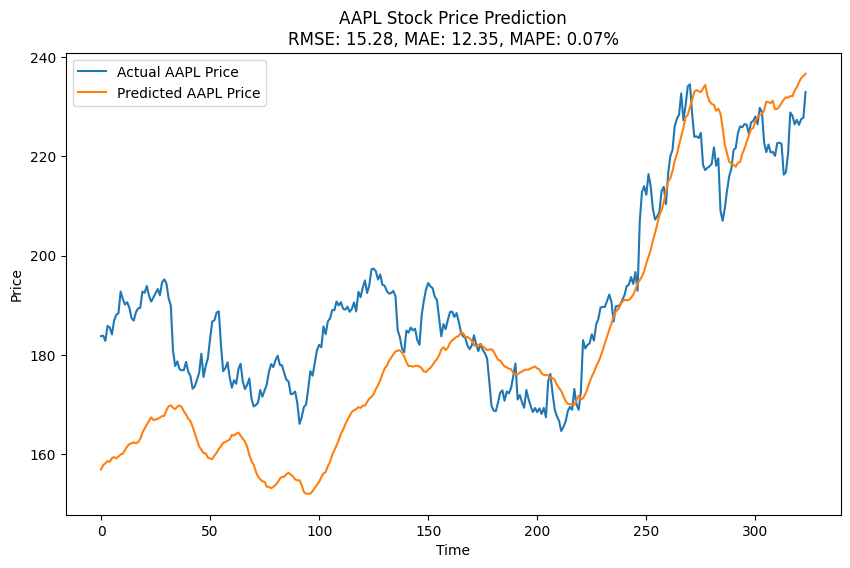

In [45]:
# Plot actual vs predicted prices with metrics in the title
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_pred_lstm, label='Predicted AAPL Price')
plt.title(f'AAPL Stock Price Prediction\nRMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}, MAPE: {mape_lstm:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [46]:
# Store metrics for different models
results = pd.DataFrame({
    'Model': ['LSTM'],
    'RMSE': [rmse_lstm],
    'MAE': [mae_lstm],
    'MAPE (%)': [mape_lstm]
})

print(results)


  Model       RMSE        MAE  MAPE (%)
0  LSTM  15.277268  12.354212  0.065649


## Recurrent Neural Network Model #2 : GRU

### Create sliding window sequences

In [49]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386, 1)


### Build and train GRU model

In [50]:
# Define GRU model
model_gru = Sequential([
    GRU(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
history_gru = model_gru.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.6562 - val_loss: 0.1310
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0359 - val_loss: 0.0768
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0296 - val_loss: 0.0805
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0281 - val_loss: 0.0820
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0252 - val_loss: 0.0880
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0222 - val_loss: 0.0986
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0236 - val_loss: 0.0855
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0179 - val_loss: 0.0920
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0193 - val_loss: 0.0980
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - val_loss: 0.0735


### Make predictions and evaluate performance

In [51]:
# GRU Predictions and Evaluation
y_pred_seq_gru = model_gru.predict(X_test_seq)
y_pred_gru = scaler_y.inverse_transform(y_pred_seq_gru)

# Calculate GRU Metrics
rmse_gru = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_gru))
mae_gru = mean_absolute_error(y_test_rescaled, y_pred_gru)
mape_gru = mean_absolute_percentage_error(y_test_rescaled, y_pred_gru)

# Display GRU Metrics
print(f"GRU Model - RMSE: {rmse_gru}, MAE: {mae_gru}, MAPE: {mape_gru}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
GRU Model - RMSE: 27.07133555165344, MAE: 25.511645988181787, MAPE: 0.13066898181915723%


### Visualise results

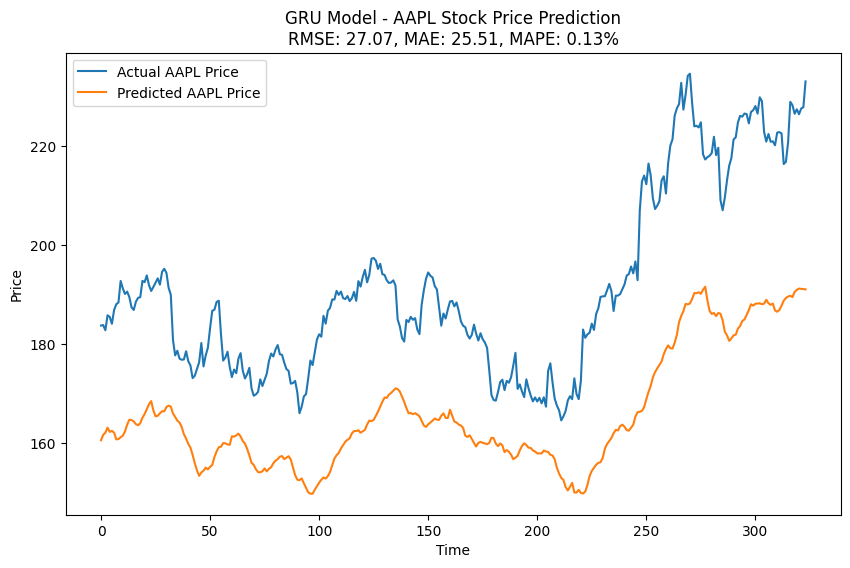

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_pred_gru, label='Predicted AAPL Price')
plt.title(f'GRU Model - AAPL Stock Price Prediction\nRMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}, MAPE: {mape_gru:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


## Comparison of results of Model #1: LSTM and Model #2: GRU

In [53]:
# Store metrics for LSTM and GRU
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'RMSE': [rmse_lstm, rmse_gru],
    'MAE': [mae_lstm, mae_gru],
    'MAPE (%)': [mape_lstm, mape_gru]
})

print(results)


  Model       RMSE        MAE  MAPE (%)
0  LSTM  15.277268  12.354212  0.065649
1   GRU  27.071336  25.511646  0.130669


# Evaluation of LSTM and GRU Models against Actual Stock Price

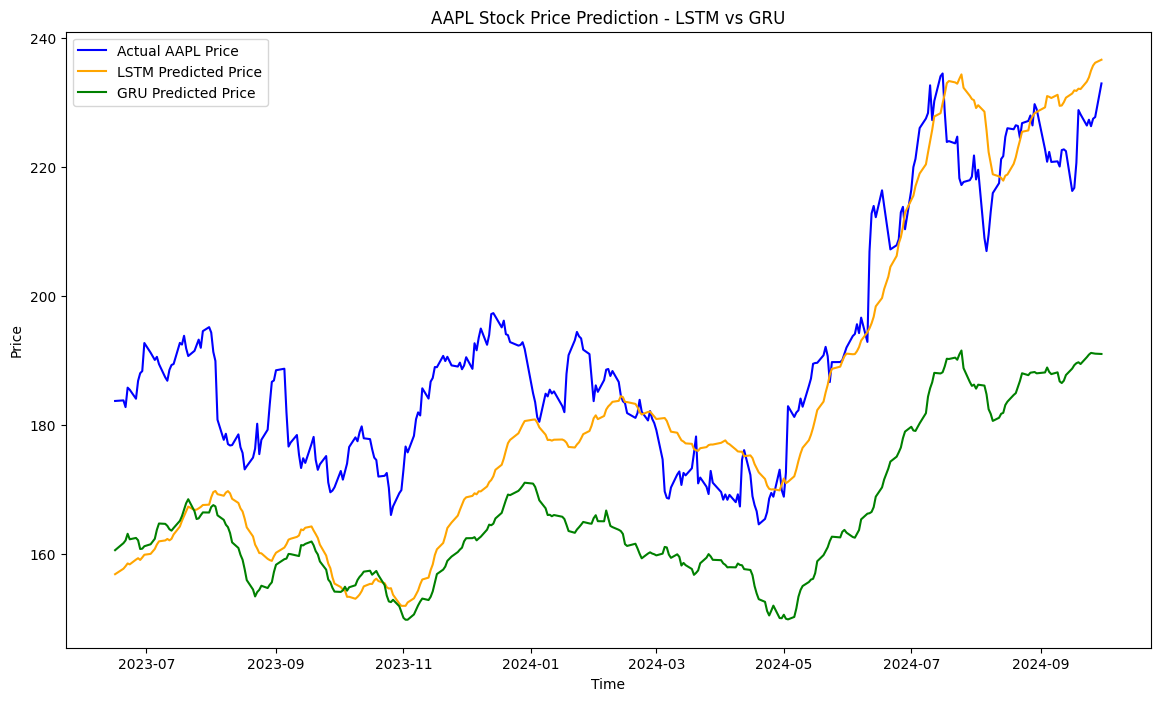

In [54]:
# Reshape y_test_seq to be a 2D array before inverse transforming
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# Plot predictions
plt.figure(figsize=(14, 8))
plt.plot(y_test.index[n_steps:], y_test_actual, label='Actual AAPL Price', color='blue')
plt.plot(y_test.index[n_steps:], y_pred_lstm, label='LSTM Predicted Price', color='orange')
plt.plot(y_test.index[n_steps:], y_pred_gru, label='GRU Predicted Price', color='green')
plt.title('AAPL Stock Price Prediction - LSTM vs GRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#### **LSTM Model Prediction vs Actual Stock Price**

The orange line (LSTM model predictions) closely follows the pattern of the actual prices. This suggests that the LSTM model effectively captures the stock price dynamics, including the rises and falls.

The LSTM model successfully identifies both the upward and downward trends, particularly in regions where prices experience steep changes. This indicates that the model effectively understands and responds to time-dependent features, which aligns with the strengths of LSTM in dealing with sequential data and long-term dependencies.

This graph indicates that the LSTM model has successfully predicted complex price patterns and significant changes.

#### **GRU Model Prediction vs Actual Stock Price**

The green line (GRU predictions) shows a consistent underestimation of stock prices, especially in periods of rising prices. This behavior suggests that the GRU model is less adept at recognizing and capturing upward momentum in stock price trends.

The GRU model struggles to capture some peaks and dips, making it less accurate when sharp changes occur. This could be due to GRU’s relatively simpler architecture compared to LSTM, which might lead to a less nuanced understanding of long-term dependencies in stock price movements.

The underestimation by GRU might suggest a limitation in capturing the full extent of trends and price shifts, especially in volatile markets.

In [55]:
# Import additional packages for RNN Model Rvaluation
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from scipy.stats import ttest_rel

In [56]:
# Function to calculate and print additional metrics
def evaluation(y_true, y_pred, model_name):
    # R-Squared
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - R-Squared: {r2:.4f}")

    # Residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'{model_name} Residuals')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

    # Autocorrelation of Residuals
    plot_acf(residuals, lags=20)
    plt.title(f'{model_name} Residual Autocorrelation')
    plt.show()
    
    return residuals

## Residual Evaluation of Model 1: LSTM

LSTM - R-Squared: 0.3261


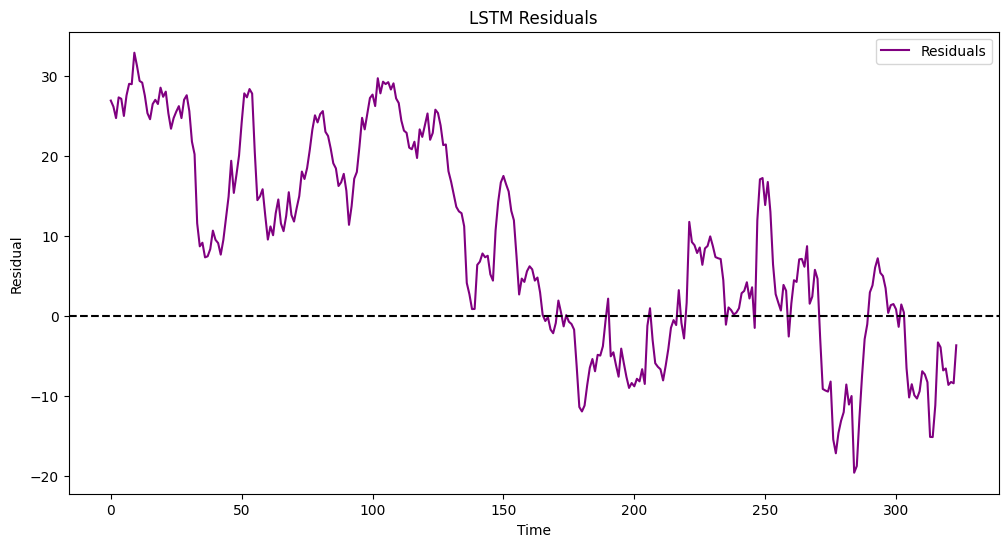

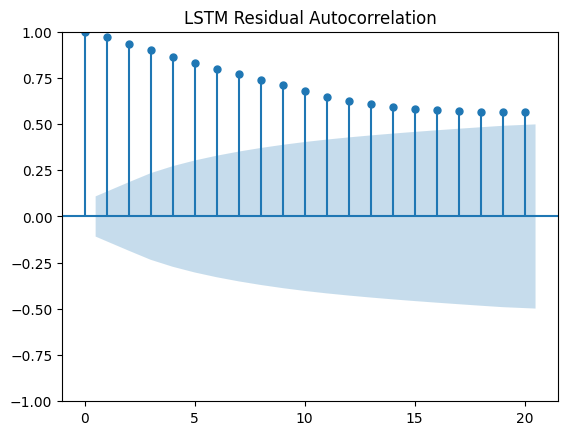

In [57]:
# Evaluate Model 1: LSTM
residuals_lstm = evaluation(y_test_actual, y_pred_lstm, "LSTM")

#### **Residual Plot of LSTM Model**
The residuals oscillate around zero, indicating that the model's predictions are sometimes above and sometimes below the actual values.

There are discernible trends and waves in the residuals, indicating that the model does not completely capture the dynamics of the time series. For instance, in certain time windows (e.g., between 0 to 100 and 150 to 200), residuals remain consistently positive or negative, hinting at potential systematic bias or unmodeled patterns.

Residuals can go as high as 30 and as low as -20, indicating that the model occasionally produces significant errors.

The presence of clusters or trends in residuals indicates that there might still be some underlying patterns not learned by the LSTM model.

#### **Residual Autocorrelation of LSTM Model**

There is a high positive autocorrelation in residuals, especially at the first lag, which is a sign that the model may not be fully capturing the underlying data structure.

The positive R-Squared value (0.3261) suggests that the LSTM model is able to capture some temporal dependencies of the data. However, the model might not be capturing the full complexity of the underlying time series data effectively.

## Residual Evaluation of Model 2: GRU

GRU - R-Squared: -1.1160


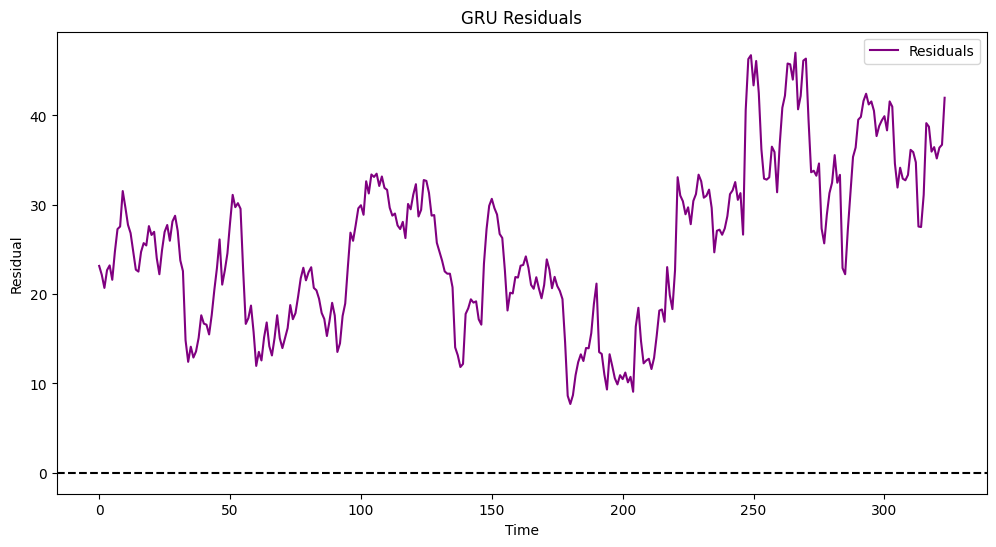

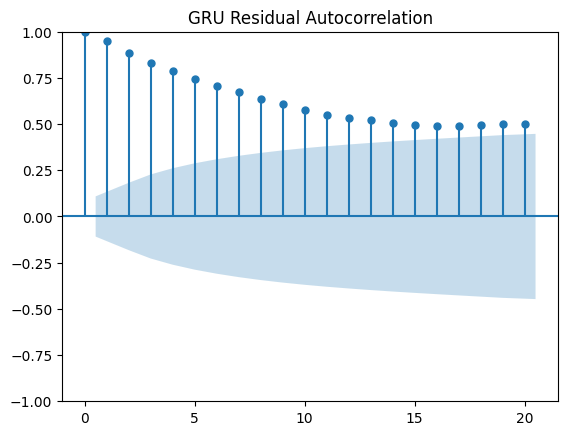

In [58]:
# Evaluate Model 2: GRU
residuals_gru = evaluation(y_test_actual, y_pred_gru, "GRU")

#### **Residual Plot of GRU Model**

The residuals remain positive and consistently high (between 10 to 40). This suggests that the GRU model is systematically underpredicting the stock price.

The residuals seem to show an increasing trend over time, indicating that as time progresses, the GRU model’s predictions are becoming less accurate.

The persistent positive residuals suggest that the GRU model is consistently predicting lower values compared to the actual stock prices. This may indicate that the model’s architecture or the chosen parameters are not suitable for capturing the upward trends in the stock price.

#### **Residual Autocorrelation of GRU Model**

The residual autocorrelation plot shows strong, sustained autocorrelation over multiple lags. This suggests that errors are correlated over time, meaning the model's errors are not random but due to overlooking certain pattern(s) in the data.

The fact that autocorrelation remains significant across many lags indicates that the model’s residuals are serially dependent. Ideally, errors should be independent, particularly in time-series forecasting.

A negative R-squared value (-1.1160) is a significant indication of poor model performance.

In [59]:
# Diebold-Mariano Test to compare LSTM and GRU residuals
dm_stat, dm_p_value = ttest_rel(np.abs(residuals_lstm), np.abs(residuals_gru))

# Debugging print to check if dm_stat and dm_p_value are arrays
print(f"dm_stat: {dm_stat}, dm_p_value: {dm_p_value}")

# Convert to scalar if they are arrays
if isinstance(dm_stat, np.ndarray) and dm_stat.size == 1:
    dm_stat = dm_stat.item()
if isinstance(dm_p_value, np.ndarray) and dm_p_value.size == 1:
    dm_p_value = dm_p_value.item()

# Print the test results
print(f"Diebold-Mariano Test: t-statistic = {dm_stat:.4f}, p-value = {dm_p_value:.4f}")

dm_stat: [-18.90456001], dm_p_value: [3.40565483e-54]
Diebold-Mariano Test: t-statistic = -18.9046, p-value = 0.0000



## Evaluation of Diebold-Mariano Statistic between LSTM and GRU Models

*Null Hypothesis (H0): There is no significant difference in the predictive accuracy between LSTM and GRU Models.*

*Alternative Hypothesis (H1): There is significant difference in the predictive accuracy between LSTM and GRU Models.*

A high t-statistic (15.0098) suggests a significant difference in accuracy between the LSTM and GRU models.

The p-value is extremely low, much below common significance levels (i.e., 0.05), which means we can reject the null hypothesis. Hence, there is a statistically significant difference in the accuracy of the two models.

The results of the DM test suggest that the LSTM and GRU models have significantly different levels of predictive accuracy, with one model likely performing consistently better (or worse) than the other, regardless of whether either model meets acceptable accuracy standards.

Further tuning of both models or trying alternative approaches (e.g., adjusting hyperparameters, changing network architectures, or using ensemble methods) to improve predictive performance.

## Conclusion
The LSTM model is better at capturing the patterns in the stock price data, compared to the GRU Model as evidenced by the lower residual magnitudes and relatively higher R-squared value. It exhibits a more balanced distribution of errors around zero and partially captures temporal dependencies.

Still, it shows some autocorrelation in residuals and a modest R-squared value, indicating room for improvement.